# 2D plate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Part I: Functions

## 1. Solution Function

In [2]:
def solution(nDof,fixDof,K,force):
    activeDof = np.setdiff1d(np.arange(nDof), fixDof)
    U = np.linalg.solve(K[np.ix_(activeDof,activeDof)],force[activeDof])
    disp = np.zeros((nDof,1))
    disp[activeDof] = U
    return disp

## 2. Shape function Q4

In [3]:
def shapeFuncQ4(xi,eta):
    shape = np.zeros((4,1))
    shape[:,0] = 1/4*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])
    
    nderiv = np.zeros((4,2))
    nderiv[0,:] = 1/4*np.array([-(1-eta),-(1-xi)])
    nderiv[1,:] = 1/4*np.array([1-eta,-(1+xi)])
    nderiv[2,:] = 1/4*np.array([1+eta,1+xi])
    nderiv[3,:] = 1/4*np.array([-(1+eta),1-xi])
    return shape, nderiv

## 3. Jacobian Function

In [4]:
def Jacobian(nodeCoord,nderiv):
    J = np.matmul(np.transpose(nodeCoord),nderiv)
    
    bT = np.transpose(nderiv)
    aT = J.T
    xT = np.linalg.solve(aT,bT)
    xyDeriv = np.transpose(xT)
    return J, xyDeriv

## 4. Gauss Quadrature-Q4

In [5]:
def gaussQuadrature(option):
    if option == 1: # full integration
        locations = np.array([[-0.577350269189626, -0.577350269189626],
                              [0.577350269189626, -0.577350269189626],
                              [0.577350269189626,  0.577350269189626],
                              [-0.577350269189626, 0.577350269189626]])
        weights = np.ones((4,1))
    else:
        locations =np.zeros((2,1))
        weights = 4*np.ones((1,1))
    return weights,locations

## 5. Stiffness matrix function - Q4

In [6]:
def formStiffness2D(nDof,nE,eNodes,nP,xy,C,h,gauss_quad_opt):
    K = np.zeros((nDof,nDof))
    gaussWt, gaussLoc = gaussQuadrature(gauss_quad_opt)
    for e in range(nE):
        id = eNodes[e,:]
        eDof = np.zeros((8,1))
        eDof[0:4,0] = id
        eDof[4:8,0] = id + nP
        eDof = eDof.flatten()

        ndof = id.size
        # loop for Gauss point
        for q in range(gaussWt.size):

            GaussPoint = gaussLoc[q,:]                                                 
            xi = GaussPoint[0]
            eta = GaussPoint[1]

            # shape functions and derivatives
            shape,nDeriv = shapeFuncQ4(xi,eta)

            # Jacobian matrix, inverse of Jacobian    
            J,xyDeriv = Jacobian(xy[id-1,:],nDeriv)

            # B matrix (Linear strain - displacement matrix)
            B = np.zeros((3,2*ndof))
            B[0,0:ndof]      = np.transpose(xyDeriv[:,0])
            B[1,ndof:(2*ndof)] = np.transpose(xyDeriv[:,1])
            B[2,0:ndof]      = np.transpose(xyDeriv[:,1])
            B[2,ndof:(2*ndof)] = np.transpose(xyDeriv[:,0])
            
            # stiffness matrix
            BT = np.transpose(B)
            detJ = np.linalg.det(J)
            Ke = np.matmul(np.matmul(BT,C),B)*h*detJ*gaussWt[q]
            
            for ii in range(np.size(Ke,0)):
                row = int(eDof[ii])-1
                for jj in range(np.size(Ke,1)):
                    col = int(eDof[jj])-1
                    K[row,col] = K[row,col] + Ke[ii,jj]
    return K

## 6. Function_Plot mesh

In [7]:
# Use when mesh is created by ourself
def PlotMesha(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi,0]
            Y[i,iel] = xy[ndi,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

In [8]:
# Use when xy and eNodes are imported from FEA sofware
def PlotMeshb(xy,eNodes,nel):
    nnel = np.size(eNodes,1)
    X = np.zeros((nnel,nel))
    Y = np.zeros((nnel,nel))
    
    for iel in range(nel):
        for i in range(nnel):
            ndi = eNodes[iel,i]
            X[i,iel] = xy[ndi-1,0]
            Y[i,iel] = xy[ndi-1,1]
    
    plt.figure(figsize=(8, 8))
    plt.axis('equal')
    plt.fill(X, Y, facecolor='none', edgecolor='purple', linewidth=1)
    plt.show()

# Part 2: Main Programe

## 2.1. Input parameters: geometry & material

In [9]:
# Material Pros
E = 2e11
h = 0.01
pois = 0.3
R1 = 0.4
R2 = 0.5
tol = 1e-6

In [10]:
# Stress- strain matriz: C - Plane strain
#E1 = E*(1-pois)/(1-2*pois)/(1+pois)
#C = E1*np.array([[1, pois/(1-pois), 0],
#                [pois/(1-pois), 1, 0],
#                [0, 0, (1-2*pois)/2/(1-pois)]])

# Stress- strain matriz: C - Plane stress
E1 =E/(1-pois**2)
C = E1*np.array([[1, pois, 0],[pois, 1, 0],[0, 0, (1-pois)/2]])

## 2.2. Import Mesh

### 2.2.1. Import nodal coordinates

In [11]:
# dfnode = pd.read_csv('NLISTQ4_NDIV5.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV10.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV20.csv', header=None)
# dfnode = pd.read_csv('NLISTQ4_NDIV40.csv', header=None)
dfnode = pd.read_csv('NLISTQ4_NDIV80.csv', header=None)

# dfnode.head(10)

In [12]:
dfnode = dfnode.dropna(axis=0)
dfnode.head()

0            1            2  3
3  NODE            X            Y  Z
4     1            1          0.5  0
5     2          0.5            1  0
6     3   0.99990362  0.509816846  0
7     4  0.999614518  0.519629908  0

In [13]:
dfnode1 = dfnode[dfnode[0].isin(["NODE"])]
dfnode = pd.concat([dfnode, dfnode1, dfnode1]).drop_duplicates(keep=False)
dfnode.head()

0            1            2  3
4  1            1          0.5  0
5  2          0.5            1  0
6  3   0.99990362  0.509816846  0
7  4  0.999614518  0.519629908  0
8  5  0.999132805  0.529435402  0

In [14]:
nP = dfnode.count(axis=0)
nP = nP[0]
nDof = 2*nP

xy = dfnode.iloc[:,1:3]
type(xy)

pandas.core.frame.DataFrame

In [15]:
xy = xy.reset_index()
xy = xy.iloc[:,1:3]
xy = xy.to_numpy(dtype=np.float32)
# xy

### 2.2.2. Import nodal connectivities

In [16]:
# dfeNode = pd.read_csv('ELISTQ4_NDIV5.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV10.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV20.csv', header=None)
# dfeNode = pd.read_csv('ELISTQ4_NDIV40.csv', header=None)
dfeNode = pd.read_csv('ELISTQ4_NDIV80.csv', header=None)

dfeNode = dfeNode.dropna(axis=0)
dfeNode = dfeNode[[6,7,8,9]]

eNodes = dfeNode[[6,7,8,9]]
nE = eNodes.count(axis=0)
nE = nE[6]

eNodes.head()

6  7      8      9
4  1  3  321.0  320.0
5  3  4  400.0  321.0
6  4  5  479.0  400.0
7  5  6  558.0  479.0
8  6  7  637.0  558.0

In [17]:
eNodes = eNodes.astype(int)
eNodes = eNodes.to_numpy(dtype=np.int32)
eNodes.shape

(6400, 4)

### 2.2.3 plot mesh

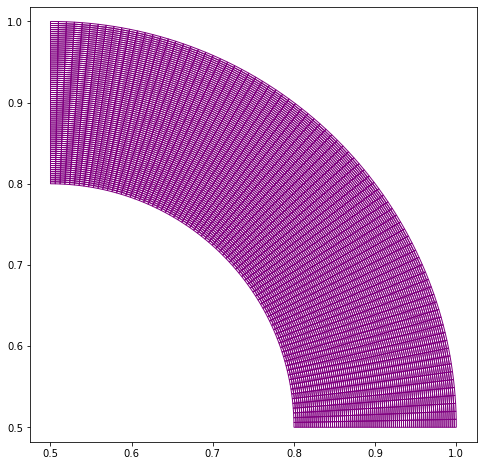

In [18]:
PlotMeshb(xy,eNodes,nE)

## 2.3. Calculate stiffness matrix

In [19]:
K = formStiffness2D(nDof,nE,eNodes,nP,xy,C,h,1)
K.shape

(13122, 13122)

## 2.4 Boundary condition

In [20]:
fixP = np.argwhere(xy[:,0]<=R2+tol)
fixDof = np.array([fixP,fixP+nP],order = 'F')
fixDof = fixDof.flatten()
fixDof

array([   1,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,
         91,   92,   93,   94,   95,   96,   97,   98,   99,  100,  101,
        102,  103,  104,  105,  106,  107,  108,  109,  110,  111,  112,
        113,  114,  115,  116,  117,  118,  119,  120,  121,  122,  123,
        124,  125,  126,  127,  128,  129,  130,  131,  132,  133,  134,
        135,  136,  137,  138,  139,  140,  141,  142,  143,  144,  145,
        146,  147,  148,  149,  150,  151,  152,  153,  154,  155,  156,
        157,  158,  159,  160, 6562, 6642, 6643, 6644, 6645, 6646, 6647,
       6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658,
       6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669,
       6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680,
       6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691,
       6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 6700, 6701, 6702,
       6703, 6704, 6705, 6706, 6707, 6708, 6709, 67

## 2.5 Loading

In [21]:
dfx = 5e7
force = np.zeros((nDof,1))

In [22]:
loadP3 = np.argwhere((xy[:,0]>=2*R1-tol) & (xy[:,1]<=R2+tol))
# loadP3
sort_index = np.argsort(xy[loadP3,0].flatten())
# sort_index

loadP = loadP3.copy()
for i in range(len(sort_index)):
    idi = sort_index[i]
    loadP[i] = loadP3[idi,0]
# loadP

In [23]:
for i in range(len(loadP)-1):
    i0 = loadP[i]
    i1 = loadP[i+1]
    dist = np.sqrt((xy[i0,0]-xy[i1,0])**2 + (xy[i0,1]-xy[i1,1])**2)
    force[i0,0] = force[i0,0] + dfx*dist/2
    force[i1,0] = force[i1,0] + dfx*dist/2
# force[loadP]

## 2.6. Solve EOM

In [24]:
disp = solution(nDof,fixDof,K,force)
# disp
dispu = disp[0:nP,0]
dispv = disp[nP:2*nP,0]

## 2.7. Postprocessing

In [25]:
scale = 0.2
xNew = xy[:,0] + scale*dispu
yNew = xy[:,1] + scale*dispv

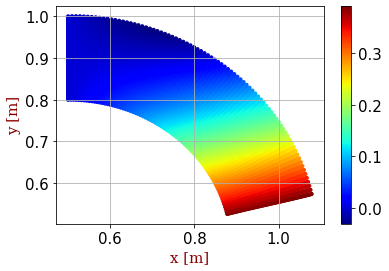

In [26]:
## plot displacement U
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispu)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)
plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [27]:
max(dispu)

0.3913053761392605

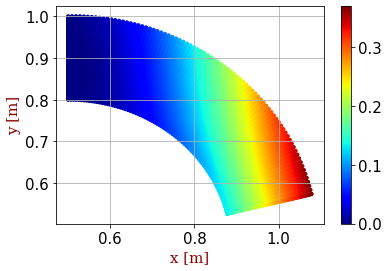

In [28]:
## plot displacement V
plt.rcParams['font.size'] = 15
ax = plt.axes()
plt.scatter(xNew, yNew, s=10, c=dispv)
plt.grid()
font1 = {'family':'serif','color':'darkred','size':15}
plt.xlabel("x [m]", fontdict = font1)

plt.ylabel("y [m]", fontdict = font1)
plt.set_cmap('jet')
plt.colorbar()

In [29]:
max(dispv)

0.3697313468542801

In [32]:
nPQ4 = np.array([36, 121, 441, 1681, 6561])

error_u = np.array([-12.70,-8.65,-1.01,-0.29,-0.12]) # %
error_v = np.array([-12.80,-3.66,-1.00,-0.28,-0.07]) # %

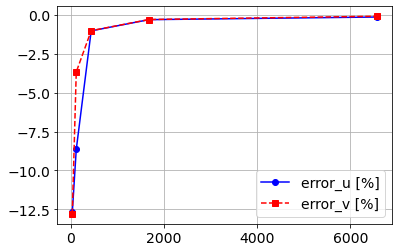

In [33]:
# plot relative errors(%) between ANSYS and our Python code
plt.rc('font', size=14)
plt.plot(nPQ4, error_u,'ob-', label="error_u [%]")
plt.plot(nPQ4, error_v,'sr--', label="error_v [%]")
plt.grid()
plt.legend()